# Wrangle and Analyze Data 
### Table of Contents
<ul> 
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#wrangle">Data Wrangling</a></li>
        <ol>
            <li><a href="#gather">Gathering Data</a></li>
            <li><a href="#assess">Assessing Data</a></li>
            <li><a href="#clean">Cleaning Data</a></li>
        </ol>
    <li><a href="#analyze">Analyzing and Visualizing Data</a></li>
    <li><a href="#ref">References</a></li>
</ul>

<a id='intro'></a>
## Introduction
Real-world data rarely comes clean. Using Python and its libraries, I will gather data in this project from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling.

The dataset that I will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

<a id='wrangle'></a>
## Data Wrangling

<a id='gather'></a>
### 1. Gathering Data
Data will be gathered from three resources:
1. The WeRateDogs Twitter Archive file that I was given.
2. The Tweet image predictions which is hosted on Udacity's server
3. Using python's library tweepy and twitter API I will retrieve each tweets' retweet and favorite counts.

In [1]:
# importing libraries
import pandas as pd
from pandas.io.json import json_normalize
import requests
import numpy as np
import os
import tweepy 
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import re
import matplotlib.pyplot as plt
%matplotlib inline

- Downloading twitter archive enhanced file manually and save it to `twitter_archive` dataframe

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

- Downloading `image_predictions.tsv` file programmatically and save it to `image_predictions` dataframe

In [3]:
# downloading image_predictions.tsv file programmatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response.content

with open(os.path.join(url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)
    
# saving it to a dataframe
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

- Gathering additional data from twitter's API

In [4]:
# query Twitter API for each tweet in the Twitter archive and save JSON in a text file
consumer_key = 'eCtaBqyFBJY0SwQEoIonXIq1x'
consumer_secret = 'v2w2bTwS7MBLgHG4KJySXUpetHZ9ZiP2Y5NOGzZtT4ukYVgESD'
access_token = '2602032643-J37FragIjHz0vJ1aYthgPdrMnNv1NbnpclXitQQ'
access_secret = 'xI83drYVULNxYDV8ws0NhjGf98sRTBjko5zIlmppeah72'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [5]:
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

2356

In [ ]:
# below code was given in the project's details
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()

# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [4]:
# taking out the information we are interested in and saving them in a dataframe
additional_info = []

with open('tweet_json.txt', encoding='utf-8') as file:
    # accessing each tweet data
    for line in file:
        tweet_data = json.loads(line)
        tweet_id = tweet_data['id']
        favorite_count = tweet_data['favorite_count']
        retweet_count = tweet_data['retweet_count']
        
        additional_info.append({'tweet_id': tweet_id, 'favorite_count': favorite_count, 'retweet_count':retweet_count})

# converting dict to dataframe        
tweet_json = pd.DataFrame(additional_info, columns=['tweet_id', 'favorite_count', 'retweet_count'])

<a id='assess'></a>
### 2. Assessing Data
After gathering each of the above pieces of data, I will assess them visually and programmatically for quality and tidiness issues:

In [5]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [6]:
twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [7]:
twitter_archive.name.sort_values()

1035     Abby
1021     Abby
938       Ace
1933     Acro
1327    Adele
        ...  
1031     very
773      very
1097     very
819      very
1385     very
Name: name, Length: 2356, dtype: object

In [8]:
len(twitter_archive[np.invert(np.isnan(twitter_archive['retweeted_status_id']))])

181

In [9]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
twitter_archive.rating_denominator.sort_values()

313       0
2335      2
516       7
1576     10
1575     10
       ... 
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [12]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
image_predictions.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [14]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
tweet_json.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,36752,7835
1,892177421306343426,31649,5801
2,891815181378084864,23840,3843
3,891689557279858688,40090,8005
4,891327558926688256,38286,8642


In [16]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 3 columns):
tweet_id          2333 non-null int64
favorite_count    2333 non-null int64
retweet_count     2333 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


#### Quality Issues (Dirty Data)

Content issues: Completeness, Validity, Accuracy and Consistency
###### `twitter_archive` table:
* Column tweet_id int instead of str (in all tables)
* The dataset includes retweets (when the columns retweeted_status_id, retweeted_status_user_id and retweeted_status timestamp are not NaN it means they are retweets)
* Missing data in the following columns: in_reply_to_status_id , in_reply_to_user_id , retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp

* Some dogs' names contain invalid names such as: a, an or the
* Timestamp datatype is object instead of datetime
* Source column includes html tags


###### `image_predictions` table:
* There is no column to detect the breed of the dog with highest confidence
* P1, p2 and p3 columns are inconsistent in capitalizations
* P1, p2 and p3 columns have invalid data (banana, paper_towel and bagel)

#### Tidiness Issues (Messy Data)
Contains structural issues, tidy datasets have specific structure:
* Each variable is a column
* Each observation is a row
* Each type of observational unit is a table

###### `twitter_archive` table:
* The four columns (doggo, floofer, pupper and puppo) related to each other

###### `Image_predictions` table:
* Table's data related to the twitter_archive table

###### `tweet_json` table:
* Table's data related to the twitter_archive table

<a id='clean'></a>
### 3. Cleaning Data

In this section, I will be performing data cleaning process:
1. Define
2. Code
3. Test

but before performing any cleaning, I have to make copies of all pieces of data

In [44]:
# copies of twitter_archive, image_predictions, tweet_json
archive = twitter_archive.copy()
images = image_predictions.copy()
tweets = tweet_json.copy()

#### Issue #1 : all three tables' data are related to each other

##### Define
Merge all three tables into one table

##### Code

In [45]:
twitter_df = pd.merge(archive, images, on = 'tweet_id')
twitter_df = pd.merge(twitter_df, tweets, on = 'tweet_id')

##### Test

In [46]:
list(twitter_df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'favorite_count',
 'retweet_count']

#### Issue #2 : Column tweet_id int instead of str (in all tables)

##### Define
Convert tweet_id column from int to object (str) datatype

##### Code

In [47]:
twitter_df['tweet_id'] = twitter_df['tweet_id'].astype(str)

##### Test

In [48]:
# Testing that the datatype has been changed in each table
twitter_df.tweet_id.dtype

dtype('O')

#### Issue #3 : The dataset includes retweets (when the columns retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp are not NaN it means they are retweets)

##### Define
Remove tweets with column retweeted_status_id that isn't NaN

##### Code

In [49]:
twitter_df = twitter_df[np.isnan(twitter_df['retweeted_status_id'])]

##### Test

In [50]:
# Make sure the three columns(retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp) equal zero
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2060
Data columns (total 30 columns):
tweet_id                      1987 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1987 non-null object
source                        1987 non-null object
text                          1987 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1987 non-null object
rating_numerator              1987 non-null int64
rating_denominator            1987 non-null int64
name                          1987 non-null object
doggo                         1987 non-null object
floofer                       1987 non-null object
pupper                        1987 non-null object
puppo                         1987 non-null object
jpg_url                       1987 no

#### Issue #4 : Missing data in the following columns: in_reply_to_status_id , in_reply_to_user_id , retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp 

##### Define
Remove the columns since we don't need them 

##### Code

In [51]:
twitter_df.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], inplace=True)

##### Test

In [52]:
# Check columns has been dropped
list(twitter_df)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'favorite_count',
 'retweet_count']

#### Issue #5 : Some dogs' names contain invalid names such as: a, an or the

##### Define
Change the names with lower letters to None

##### Code

In [53]:
# I don't know how many name that is invalid but I noticed a pattern where each lower cased name is invalid 
#so I will replace them to None
twitter_df['name'] = twitter_df['name'].str.replace('^[a-z]+', 'None')

##### Test

In [54]:
twitter_df.name.value_counts()

None        644
Cooper       10
Oliver       10
Charlie      10
Lucy          9
           ... 
Roscoe        1
Lolo          1
Devón         1
Gert          1
Philippe      1
Name: name, Length: 912, dtype: int64

#### Issue #6 : Timestamp datatype is object instead of datetime

##### Define
Convert timestamp to datetime datatype

##### Code

In [55]:
twitter_df['timestamp'] = pd.to_datetime(twitter_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

##### Test

In [56]:
twitter_df.timestamp.dtypes

datetime64[ns, UTC]

#### Issue #7 : Source column includes html tags

##### Define
Clean source column from html tags

##### Code

In [57]:
for source in twitter_df['source']:
    clean = re.compile('<.*?>')
    clean_source = re.sub(clean,'',source)
    twitter_df['source'] = twitter_df['source'].replace(source,clean_source)

##### Test

In [58]:
twitter_df.source.value_counts()

Twitter for iPhone    1949
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

#### Issue #8 :  There is no column to detect the breed of the dog with highest confidence

##### Define
Create a new column with the breed of dogs based on the highest confidence rate

##### Code

In [59]:
# Since p1, p2, p3 have the same length
# iterate on them and compare the rating to get the highest one
dog_breed = []
dog_p = []
for index, row in twitter_df.iterrows(): 
        if row['p1_conf'] > row['p2_conf'] and row['p1_conf'] > row['p3_conf']:
            breed = row['p1'] 
            p_dog = row['p1_dog']
        
        elif dog['p2_conf'] > row['p1_conf'] and row['p2_conf'] > row['p3_conf']:
            breed = row['p2']
            p_dog = row['p2_dog']
        
        else:
            breed = row['p3']
            p_dog = row['p3_dog']
            
        dog_breed.append(breed)
        dog_p.append(p_dog)
    
twitter_df['breed'] = dog_breed
twitter_df['prediction'] = dog_p

In [60]:
# drop the columns since we don't need them anymore
twitter_df = twitter_df.drop(columns = ['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'])

##### Test

In [61]:
list(twitter_df)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'favorite_count',
 'retweet_count',
 'breed',
 'prediction']

#### Issue #9: P1, p2 and p3 columns are inconsistent in capitalization

##### Define
Capitalize the derived column (breed)

##### Code

In [62]:
twitter_df.breed = twitter_df.breed.str.capitalize()

##### Test

In [63]:
twitter_df.breed.value_counts()

Golden_retriever      139
Labrador_retriever     93
Pembroke               88
Chihuahua              79
Pug                    54
                     ... 
Silky_terrier           1
Tick                    1
Rain_barrel             1
Lawn_mower              1
Pool_table              1
Name: breed, Length: 374, dtype: int64

#### Issue #10: P1, p2 and p3 columns have invalid data (banana, paper_towel and bagel)

##### Define
Remove rows with dog false prediction

##### Code

In [64]:
twitter_df.prediction.value_counts()

True     1470
False     517
Name: prediction, dtype: int64

In [65]:
for index, row in twitter_df.iterrows(): 
    if row.prediction == False:
        twitter_df.drop(labels=index, inplace=True)

In [66]:
# drop prediction column 
twitter_df.drop(columns = 'prediction', inplace=True)

##### Test

In [67]:
# it is the number of the images that was predicted to be dogs
len(twitter_df)

1470

In [68]:
# make sure prediction column dropped and 
twitter_df.sample()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,favorite_count,retweet_count,breed
423,807106840509214720,2016-12-09 06:17:20+00:00,Twitter for iPhone,This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,None,None,None,None,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,122667,57783,Chihuahua


#### Issue #11 : The four columns (doggo, floofer, pupper and puppo) are related to each other

##### Define
Extract each dog's stage and append it to a new column

##### Code

In [69]:
# replace None
twitter_df['doggo'] = twitter_df['doggo'].replace('None', '')
twitter_df['floofer'] = twitter_df['floofer'].replace('None','')
twitter_df['pupper'] = twitter_df['pupper'].replace('None', '')
twitter_df['puppo'] = twitter_df['puppo'].replace('None', '')

In [71]:
twitter_df['dog_stage'] = twitter_df['doggo'] + twitter_df['floofer'] + twitter_df['pupper'] + twitter_df['puppo']
twitter_df['dog_stage'] = twitter_df['dog_stage'].replace('', np.nan)

In [72]:
twitter_df.loc[twitter_df['dog_stage'] == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'
twitter_df.loc[twitter_df['dog_stage'] == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
twitter_df.loc[twitter_df['dog_stage'] == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'

In [73]:
# Drop the four columns 
twitter_df.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

##### Test

In [74]:
list(twitter_df)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'jpg_url',
 'img_num',
 'favorite_count',
 'retweet_count',
 'breed',
 'dog_stage']

In [75]:
twitter_df.dog_stage.value_counts()

pupper            144
doggo              47
puppo              19
doggo, pupper       8
floofer             7
doggo, puppo        1
doggo, floofer      1
Name: dog_stage, dtype: int64

#### Issue #12: Un used columns
##### Define 
Drop columns we don't need (img_num, expanded_urls)

##### Code

In [48]:
twitter_df.drop(columns = ['img_num', 'expanded_urls'], inplace = True)

##### Test

In [49]:
list(twitter_df)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'jpg_url',
 'favorite_count',
 'retweet_count',
 'breed',
 'dog_stage']

In [50]:
twitter_df.to_csv('twitter_archive_master.csv', index=False)

<a id='analyze'></a>
## Analyzing and Visualizing Data

#### #1 Insight: Analyzing WeRateDogs activity
Firstly, lets check the account's activity overtime

In [51]:
# Using grouper counting number of tweets per month
monthly_tweets = twitter_df.groupby(pd.Grouper(key='timestamp', freq='M')).count()
# dropping columns we don't need
monthly_tweets.drop(monthly_tweets.columns.difference(['tweet_id','timestamp']), 1, inplace=True)
monthly_tweets.reset_index(inplace=True)
monthly_tweets.sample()

,timestamp,tweet_id
6,2016-05-31 00:00:00+00:00,40


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


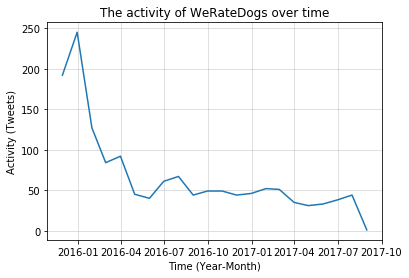

In [52]:
# Plotting
plt.title('The activity of WeRateDogs over time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Activity (Tweets)')
plt.grid(alpha=0.5)
plt.plot(monthly_tweets['timestamp'], monthly_tweets['tweet_id']);

In [53]:
# Getting the peak 
monthly_tweets.sort_values(by='tweet_id')

,timestamp,tweet_id
21,2017-08-31 00:00:00+00:00,1
17,2017-04-30 00:00:00+00:00,31
18,2017-05-31 00:00:00+00:00,33
16,2017-03-31 00:00:00+00:00,35
19,2017-06-30 00:00:00+00:00,38
6,2016-05-31 00:00:00+00:00,40
12,2016-11-30 00:00:00+00:00,44
9,2016-08-31 00:00:00+00:00,44
20,2017-07-31 00:00:00+00:00,44
5,2016-04-30 00:00:00+00:00,45


From the above, we notice that the activity of WeRateDogs account is decreasing over time. Also, we can see that the peak of the activity is on 2015-12-31 and its bottom is 2017-8-31 in this dataset.

#### #2 Insight: Analyzing top 10 dogs breeds occurrences in the account and favorite counts 
Lets see the most occurred 10 dog breed in the account:

In [54]:
# Getting most occurred breeds
breed_dogs = twitter_df.groupby(pd.Grouper(key='breed')).count()
breed_dogs.drop(breed_dogs.columns.difference(['tweet_id','breed']), 1, inplace=True)
breed_dogs.reset_index(inplace=True)
occur = breed_dogs.nlargest(10, ['tweet_id']) 
occur

,breed,tweet_id
9,Golden_retriever,139
22,Labrador_retriever,93
6,Pembroke,88
0,Chihuahua,79
14,Pug,54
18,Chow,41
7,Samoyed,39
4,Pomeranian,38
68,Toy_poodle,37
16,Malamute,29


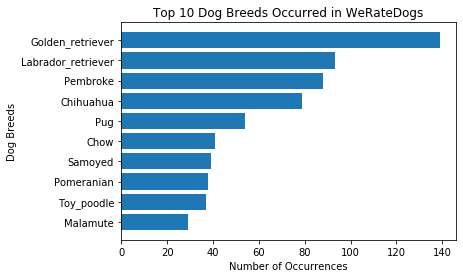

In [55]:
# Plotting
fig, ax = plt.subplots(figsize=(6,4))

breeds = occur['breed']
y_pos = np.arange(len(breeds))

ax.barh(y_pos, occur['tweet_id'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(breeds)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Occurrences')
ax.set_ylabel('Dog Breeds')
ax.set_title('Top 10 Dog Breeds Occurred in WeRateDogs')

plt.show()

Now lets see if those breeds are the most favorites to people by counting favorite counts

In [56]:
# Get top 10 breeds based on favorite counts
favorites_df = twitter_df.groupby(['breed','favorite_count'], as_index=False).count()
favorites_df.drop(favorites_df.columns.difference(['breed','favorite_count']), 1, inplace=True)

In [57]:
favorites_df.sample(3)

,breed,favorite_count
938,Miniature_poodle,5509
482,German_shepherd,10607
155,Briard,2571


In [58]:
# Get top 10 favorites
favorites = favorites_df.nlargest(10, ['favorite_count']) 
favorites

,breed,favorite_count
826,Labrador_retriever,158810
842,Lakeland_terrier,135407
291,Chihuahua,122667
467,French_bulldog,118129
434,Eskimo_dog,117290
415,English_springer,100727
1360,Standard_poodle,89529
636,Golden_retriever,79547
212,Chesapeake_bay_retriever,75718
698,Italian_greyhound,73502


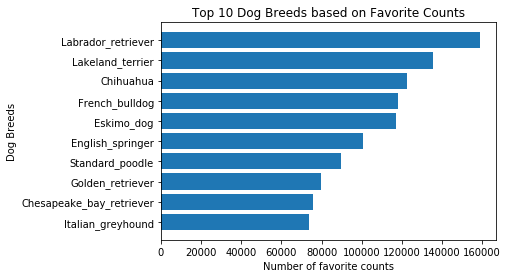

In [59]:
# Plotting
fig, ay = plt.subplots(figsize=(6,4))

fav = favorites['breed']
y_pos = np.arange(len(fav))

ay.barh(y_pos, favorites['favorite_count'], align='center')
ay.set_yticks(y_pos)
ay.set_yticklabels(fav)
ay.invert_yaxis()  # labels read top-to-bottom
ay.set_xlabel('Number of favorite counts')
ay.set_ylabel('Dog Breeds')
ay.set_title('Top 10 Dog Breeds based on Favorite Counts')

plt.show()

From the above plots, we can see that there are two breeds that people like and occurrs alot which are: Laborador_retriever and Chihuahua dogs.

#### #3 Insight: Most occurred dog stage in WeRateDogs

In [60]:
twitter_df.dog_stage.value_counts()

pupper     152
doggo       47
puppo       20
floofer      8
Name: dog_stage, dtype: int64

The above shows that the most occurred dog stage (that was successfully identified) is pupper, which is based on a dogtionary it is a small doggo. I find it convincing that it is the most occurred stage as the majority of people tend to like puppies more.

<a id='ref'></a>
## References
* A. D. H. A. D. Howland, “Read Relative Lines in a text document and convert to Pandas DF,” Stack Overflow, Aug-2018. [Online]. Available: https://stackoverflow.com/questions/51711750/read-relative-lines-in-a-text-document-and-convert-to-pandas-df. [Accessed: 03-Jan-2020].

* Tidy data. [Online]. Available: https://vita.had.co.nz/papers/tidy-data.html. [Accessed: 03-Jan-2020].

* Regular Expressions. [Online]. Available: http://users.cs.cf.ac.uk/Dave.Marshall/Internet/NEWS/regexp.html. [Accessed: 04-Jan-2020].

* J. L. G. Quintero, “How to strip html tags from a string in Python,” Medium, 22-Aug-2017. [Online]. Available: https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44. [Accessed: 04-Jan-2020].

* RomanRoman 72.8k133133 gold badges294294 silver badges399399 bronze badges, waitingkuowaitingkuo 49.7k2020 gold badges9494 silver badges107107 bronze badges, viddik13viddik13 3, cs95cs95 185k3535 gold badges289289 silver badges350350 bronze badges, Wes McKinneyWes McKinney 65.5k2222 gold badges121121 silver badges9898 bronze badges, e9te9t 10.5k55 gold badges1818 silver badges2222 bronze badges, cheekybastardcheekybastard 4, PJayPJay 1, Lucas BLucas B 1, piRSquaredpiRSquared 194k2727 gold badges215215 silver badges379379 bronze badges, Grag2015Grag2015 34944 silver badges1010 bronze badges, Pedro LobitoPedro Lobito 58.6k2020 gold badges157157 silver badges188188 bronze badges, ZachZach 94566 silver badges1010 bronze badges, Herpes Free EngineerHerpes Free Engineer 1, ZeitgeistZeitgeist 52566 silver badges1818 bronze badges, HosseinHossein 30111 silver badge1010 bronze badges, RomainRomain 1421212 bronze badges, James L.James L. 4, shubham ranjanshubham ranjan 12966 bronze badges, mjr2000mjr2000 6255 bronze badges, and IanIan 54655 silver badges1313 bronze badges, “How to iterate over rows in a DataFrame in Pandas?,” Stack Overflow, 01-May-1963. [Online]. Available: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas. [Accessed: 04-Jan-2020].

* “pandas.melt¶,” pandas.melt - pandas 0.25.3 documentation. [Online]. Available: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html. [Accessed: 04-Jan-2020].

* “pandas.Grouper¶,” pandas.Grouper - pandas 0.25.3 documentation. [Online]. Available: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html. [Accessed: 04-Jan-2020].

* sgerbhctimsgerbhctim 1, MaxUMaxU 141k1616 gold badges182182 silver badges228228 bronze badges, YO and BEN_WYO and BEN_W 174k1111 gold badges6565 silver badges100100 bronze badges, GollyJerGollyJer 8, TaieTaie 751616 bronze badges, and Isaac TaylorIsaac Taylor 1, “How to delete all columns in DataFrame except certain ones?,” Stack Overflow, 01-Sep-1967. [Online]. Available: https://stackoverflow.com/questions/45846189/how-to-delete-all-columns-in-dataframe-except-certain-ones. [Accessed: 04-Jan-2020].

* Shivam_kCheck out this Author's contributed articles., Shivam_k, and Check out this Author's contributed articles., “Get n-largest values from a particular column in Pandas DataFrame,” GeeksforGeeks, 18-Dec-2018. [Online]. Available: https://www.geeksforgeeks.org/get-n-largest-values-from-a-particular-column-in-pandas-dataframe/. [Accessed: 04-Jan-2020].

* “Horizontal bar chart¶,” Horizontal bar chart - Matplotlib 3.1.1 documentation. [Online]. Available: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barh.html. [Accessed: 04-Jan-2020].